## Реализация метода градиентного спуска

In [1]:
from typing import List, Iterable

import numpy as np
import matplotlib.pyplot as plt
import abc

import numpy as np
import pandas as pd
from numpy import linalg
from scipy.stats import mode

from sklearn.preprocessing import LabelEncoder
import time

In [2]:
class BaseLoss(abc.ABC):
    @abc.abstractmethod
    def calc_loss(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> float:
        raise NotImplementedError

    @abc.abstractmethod
    def calc_grad(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> np.ndarray:
        raise NotImplementedError

Реализация класса MSELoss.

MSE loss
$$
Q(w, X, y) = \frac{1}{\ell} || Xw - y ||^2
$$
Gradient
$$
\nabla_w Q(w, X, y) = \frac{2}{\ell} X^T(Xw-y)
$$

In [3]:
class MSELoss(BaseLoss):
    def calc_loss(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> float:
        Q = (linalg.norm(np.dot(X,w)-y))**2/len(y)
        return Q
             
             
    def calc_grad(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> np.ndarray:
        L = np.dot(X,w) - y
        Xt = np.transpose(X)
        Grad = 2*np.dot(Xt, L)/len(y)
        return Grad

In [4]:
loss = MSELoss()

X = np.arange(200).reshape(20, 10)
y = np.arange(20)

# Создадим какой-то вектор весов
w = np.arange(10)

# Выведем значение лосса и градиента на этом датасете с этим вектором весов

print(loss.calc_loss(X, y, w))
print(loss.calc_grad(X,y ,w))
# Проверка, что методы реализованы правильно
assert loss.calc_loss(X, y, w) == 27410283.5, "Метод calc_loss реализован неверно"
assert np.allclose(loss.calc_grad(X, y, w), np.array([1163180., 1172281., 1181382., 1190483., 
                                                      1199584., 1208685., 1217786., 1226887., 
                                                      1235988., 1245089.])), "Метод calc_grad реализован неверно"

27410283.5
[1163180. 1172281. 1181382. 1190483. 1199584. 1208685. 1217786. 1226887.
 1235988. 1245089.]


**Реализация градиентоного спуска** 
$$
w^t = w^{t-1} - \eta \nabla_{w} Q(w^{t-1}, X, y)
$$

In [5]:
def gradient_descent(w_init: np.ndarray, X: np.ndarray, y: np.ndarray, 
                        loss: BaseLoss, lr: float, n_iterations: int = 100000) -> List[np.ndarray]:
    
    W = []
    
    for i in range(n_iterations):
        w_init_new = w_init - lr*loss.calc_grad(X, y, w_init)
        W.append(w_init_new)
        w_init = w_init_new
        
    return W
        
   

In [6]:
# Создаём датасет из двух переменных и реального вектора зависимости w_true

np.random.seed(1337)

n_features = 2
n_objects = 300
batch_size = 10
num_steps = 43

w_true = np.random.normal(size=(n_features, ))

X = np.random.uniform(-5, 5, (n_objects, n_features))
X *= (np.arange(n_features) * 2 + 1)[np.newaxis, :]  
y = X.dot(w_true) + np.random.normal(0, 1, (n_objects))
w_init = np.random.uniform(-2, 2, (n_features))

print(X.shape)
print(y.shape)

(300, 2)
(300,)


Создадим экземпляр класса MSELoss(), посомтрели на ошибку на первом и последнем шаге


In [7]:
loss = MSELoss()
w_list = gradient_descent(w_init, X, y, loss, 0.01)
w_list[1]
w_list[-1]

array([-0.66805599, -0.48985109])

In [8]:
def plot_gd(w_list: Iterable, X: np.ndarray, y: np.ndarray, loss: BaseLoss):
    w_list = np.array(w_list)
    meshgrid_space = np.linspace(-2, 2, 100)
    A, B = np.meshgrid(meshgrid_space, meshgrid_space)

    levels = np.empty_like(A)
    for i in range(A.shape[0]):
        for j in range(A.shape[1]):
            w_tmp = np.array([A[i, j], B[i, j]])
            levels[i, j] = loss.calc_loss(X, y, w_tmp)

    plt.figure(figsize=(15, 6))
    plt.title("GD trajectory")
    plt.xlabel(r'$w_1$')
    plt.ylabel(r'$w_2$')
    plt.xlim(w_list[:, 0].min() - 0.1, 
             w_list[:, 0].max() + 0.1)
    plt.ylim(w_list[:, 1].min() - 0.1,
             w_list[:, 1].max() + 0.1)
    plt.gca().set_aspect('equal')

    CS = plt.contour(A, B, levels, levels=np.logspace(0, 1, num=20), cmap=plt.cm.rainbow_r)
    CB = plt.colorbar(CS, shrink=0.8, extend='both')

    plt.scatter(w_list[:, 0], w_list[:, 1])
    plt.plot(w_list[:, 0], w_list[:, 1])

    plt.show()

**Реализация стохастического градиентоного спуска**

При помощи функций **gradient_descent** и **plot_sgd** нарисуем траекторию стахостического градиентного спуска для разных значений длины шага. 

длина шага 0.0001


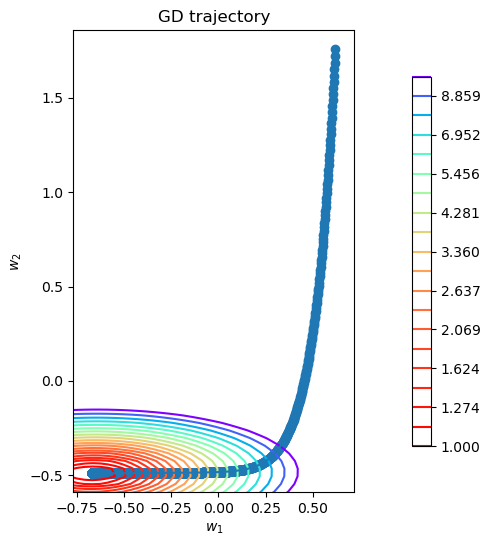

длина шага 0.001


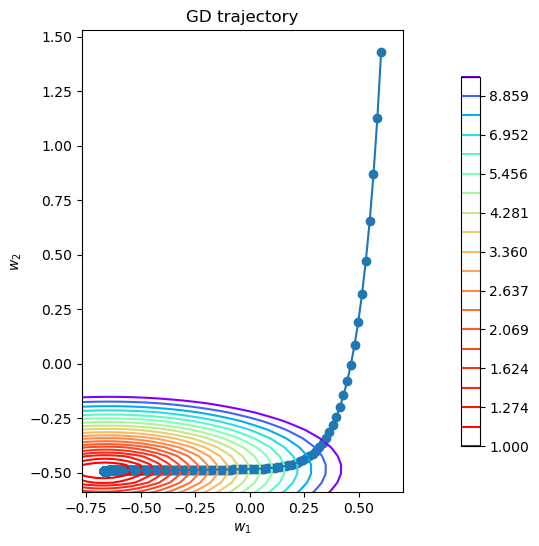

длина шага 0.01


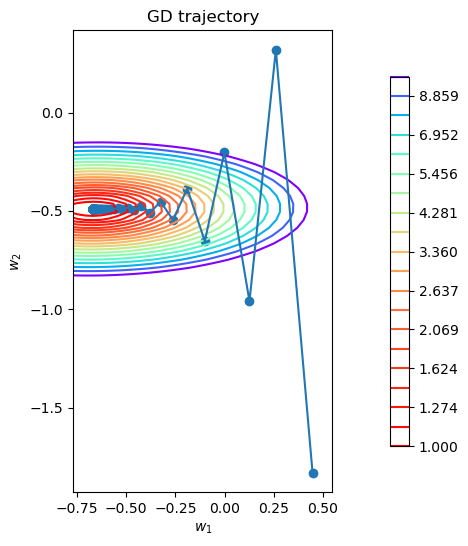

длина шага 0.012


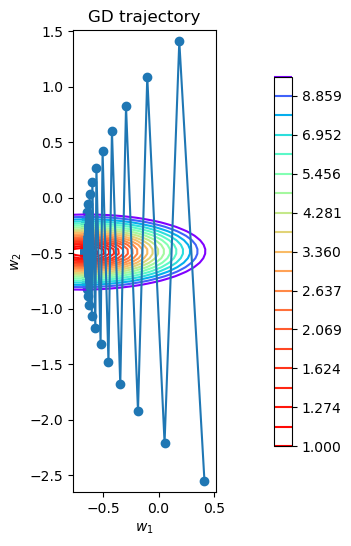

In [9]:
lr = [0.0001, 0.001, 0.01, 0.012]

for i in range(len(lr)):
    w_list = gradient_descent(w_init, X, y, loss, lr[i])
    print('длина шага', lr[i])
    plot_gd(w_list, X, y, loss)

In [10]:
def stochastic_gradient_descent(w_init: np.ndarray, X: np.ndarray, y: np.ndarray, 
                        loss: BaseLoss, lr: float, batch_size: int, n_iterations: int = 1000) -> List[np.ndarray]:
    W = []
    
    for i in range(n_iterations):
        batch_indices = np.random.choice(X.shape[0], size=batch_size, replace=False)
        X_batch = X[batch_indices]
        y_batch = y[batch_indices]
        w_init_new = w_init - lr*loss.calc_grad(X_batch, y_batch, w_init)
        W.append(w_init_new)
        w_init = w_init_new
        
    return W

In [11]:
def plot_sgd(w_list: Iterable, X: np.ndarray, y: np.ndarray, loss: BaseLoss):
    w_list = np.array(w_list)
    meshgrid_space = np.linspace(-2, 2, 100)
    A, B = np.meshgrid(meshgrid_space, meshgrid_space)

    levels = np.empty_like(A)
    for i in range(A.shape[0]):
        for j in range(A.shape[1]):
            w_tmp = np.array([A[i, j], B[i, j]])
            levels[i, j] = loss.calc_loss(X, y, w_tmp)

    plt.figure(figsize=(15, 6))
    plt.title("SGD trajectory")
    plt.xlabel(r'$w_1$')
    plt.ylabel(r'$w_2$')
    plt.xlim(w_list[:, 0].min() - 0.1, 
             w_list[:, 0].max() + 0.1)
    plt.ylim(w_list[:, 1].min() - 0.1,
             w_list[:, 1].max() + 0.1)
    plt.gca().set_aspect('equal')

    CS = plt.contour(A, B, levels, levels=np.logspace(0, 1, num=20), cmap=plt.cm.rainbow_r)
    CB = plt.colorbar(CS, shrink=0.8, extend='both')

    plt.scatter(w_list[:, 0], w_list[:, 1])
    plt.plot(w_list[:, 0], w_list[:, 1])

    plt.show()

batch size = 1 , lr =  0.0001
____ 0.06229758262634277 seconds _____


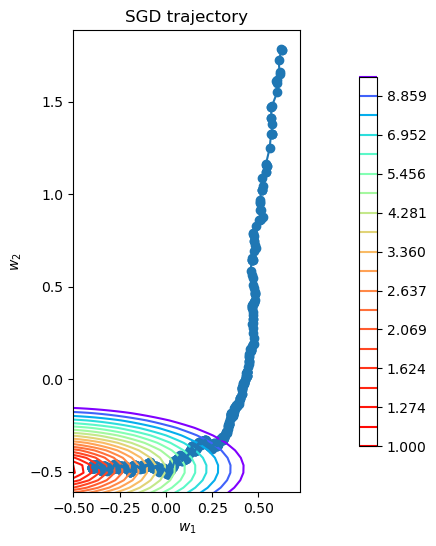

batch size = 1 , lr =  0.001
____ 0.04355335235595703 seconds _____


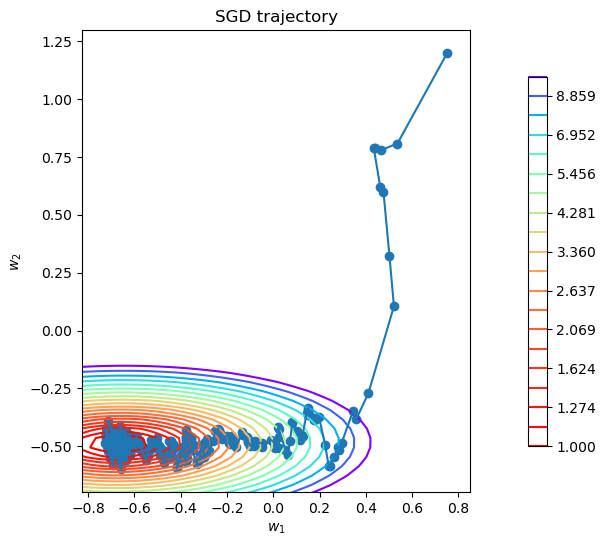

batch size = 1 , lr =  0.01
____ 0.04305386543273926 seconds _____


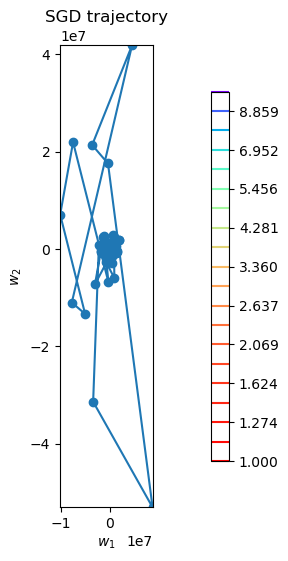

batch size = 1 , lr =  0.012
____ 0.04591727256774902 seconds _____


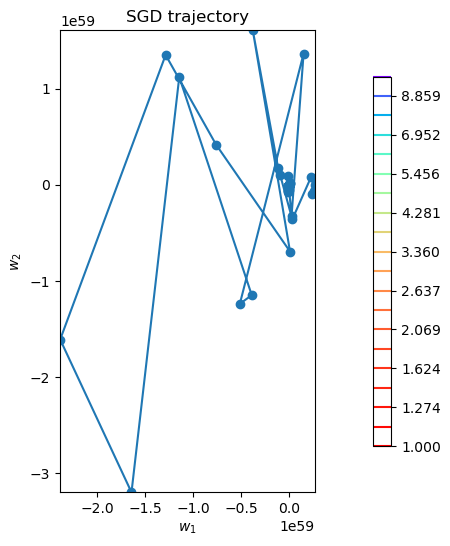

batch size = 10 , lr =  0.0001
____ 0.061605215072631836 seconds _____


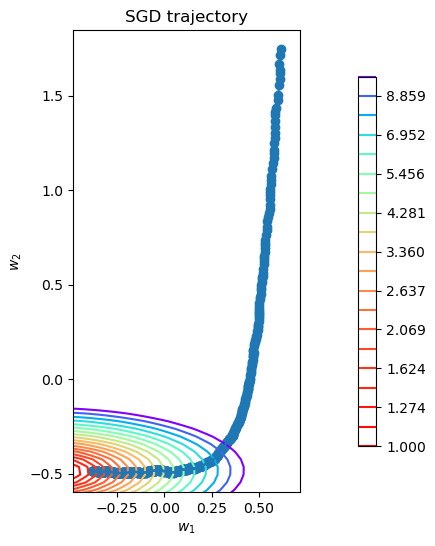

batch size = 10 , lr =  0.001
____ 0.04713010787963867 seconds _____


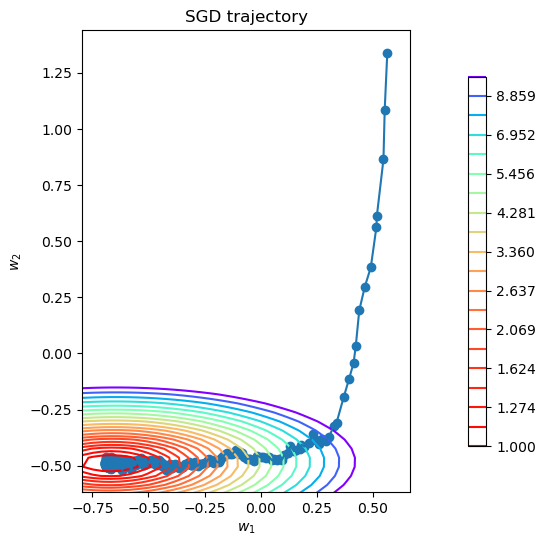

batch size = 10 , lr =  0.01
____ 0.04771852493286133 seconds _____


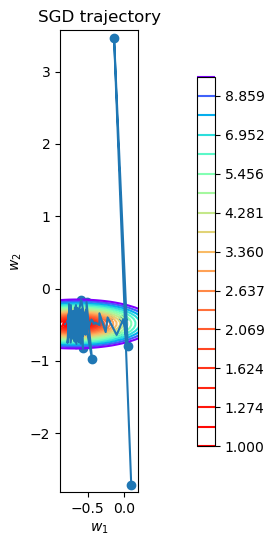

batch size = 10 , lr =  0.012
____ 0.04359698295593262 seconds _____


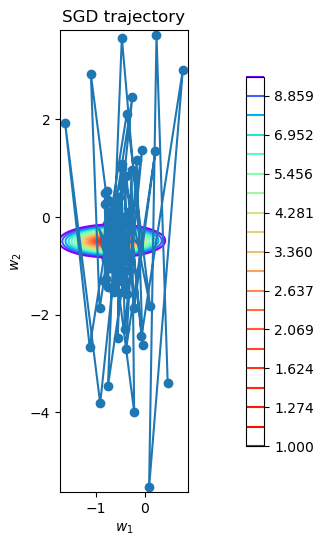

batch size = 100 , lr =  0.0001
____ 0.04955410957336426 seconds _____


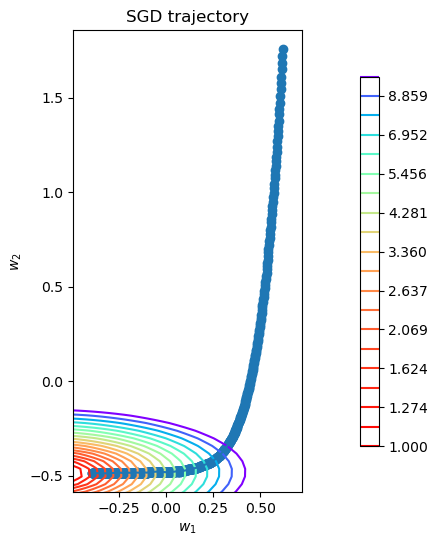

batch size = 100 , lr =  0.001
____ 0.04781341552734375 seconds _____


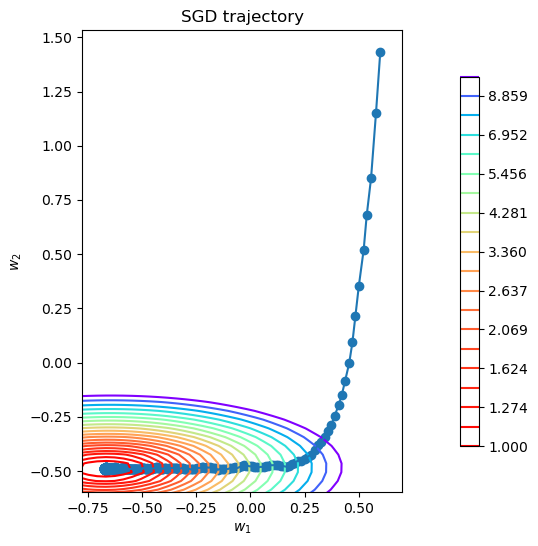

batch size = 100 , lr =  0.01
____ 0.04864096641540527 seconds _____


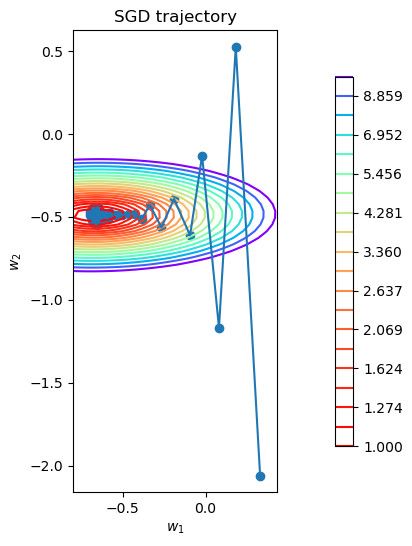

batch size = 100 , lr =  0.012
____ 0.044008493423461914 seconds _____


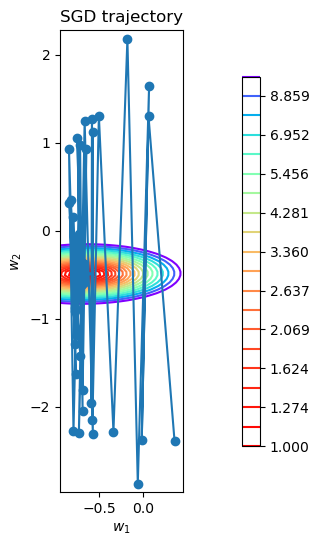

batch size = 200 , lr =  0.0001
____ 0.04754281044006348 seconds _____


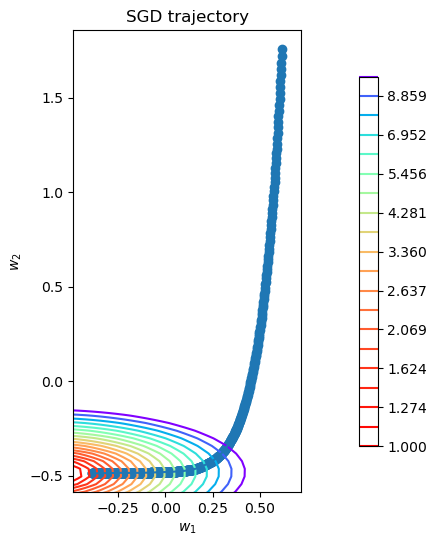

batch size = 200 , lr =  0.001
____ 0.055327653884887695 seconds _____


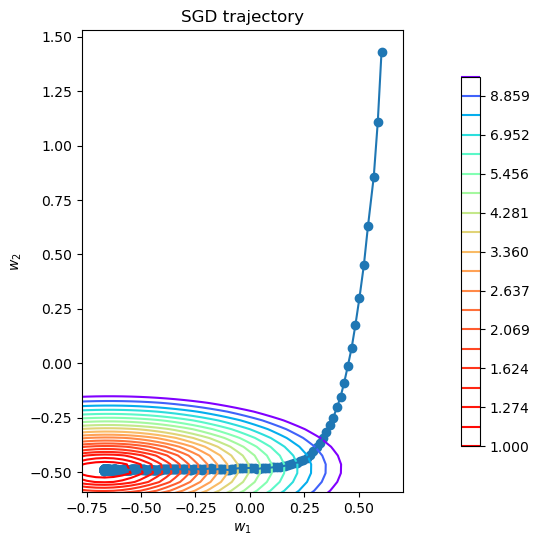

batch size = 200 , lr =  0.01
____ 0.04890275001525879 seconds _____


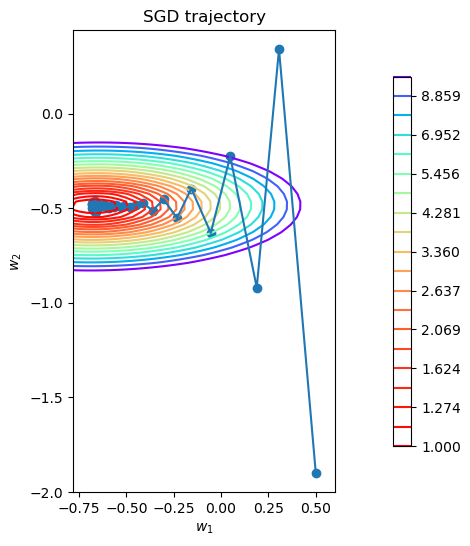

batch size = 200 , lr =  0.012
____ 0.058838605880737305 seconds _____


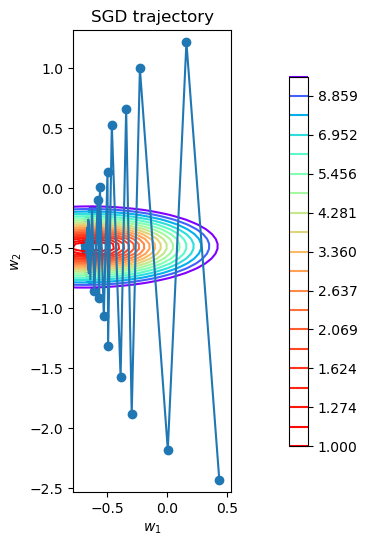

In [12]:
lr = [0.0001, 0.001, 0.01, 0.012]
batch_size = [1, 10, 100, 200]

for j in range(len(batch_size)):
    for i in range(len(lr)):
        start_time = time.time()
        w_list = stochastic_gradient_descent(w_init, X, y, loss, lr[i], batch_size[j])
        print('batch size =', batch_size[j], ',', 'lr = ', lr[i])
        print('____ %s seconds _____'%(time.time() - start_time))
        plot_sgd(w_list, X, y, loss)

**Реализация стохастического градиентоного спуска с затухающим шагом**

In [13]:
def stochastic_gradient_descent(w_init: np.ndarray, X: np.ndarray, y: np.ndarray, 
                        loss: BaseLoss, lr: float, batch_size: int, p: float, n_iterations: int = 1000) -> List[np.ndarray]:

    s0 = 1
    W = []
    
    for i in range(n_iterations):
        batch_indices = np.random.choice(X.shape[0], size=batch_size)
        X_batch = X[batch_indices]
        y_batch = y[batch_indices]
        w_init_new = w_init - lr*((s0 / (s0 + i))**p)*loss.calc_grad(X_batch, y_batch, w_init)
        W.append(w_init_new)
        w_init = w_init_new
        
    return W

p = 0.1


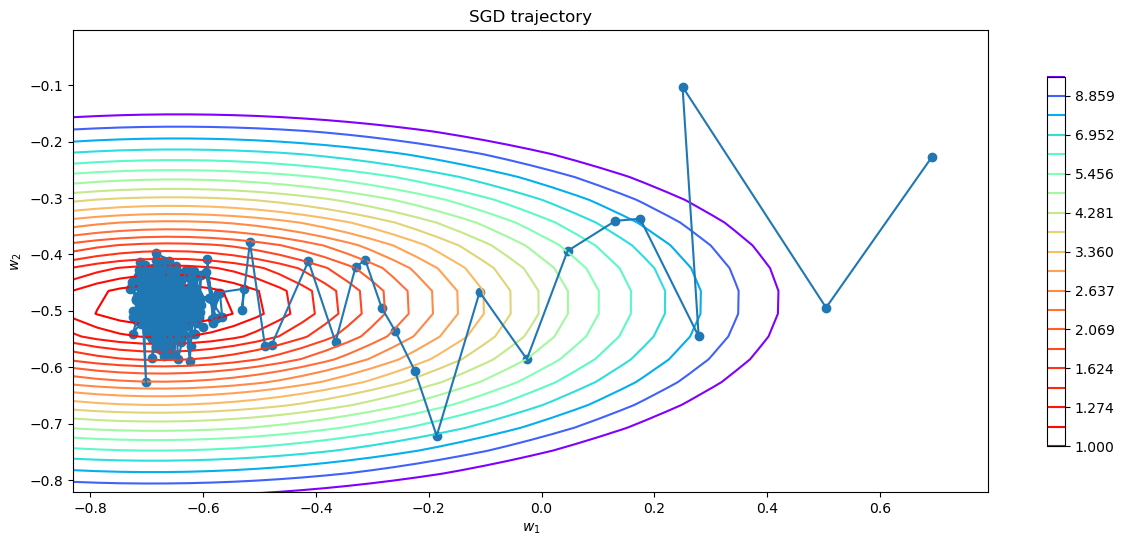

p = 0.3


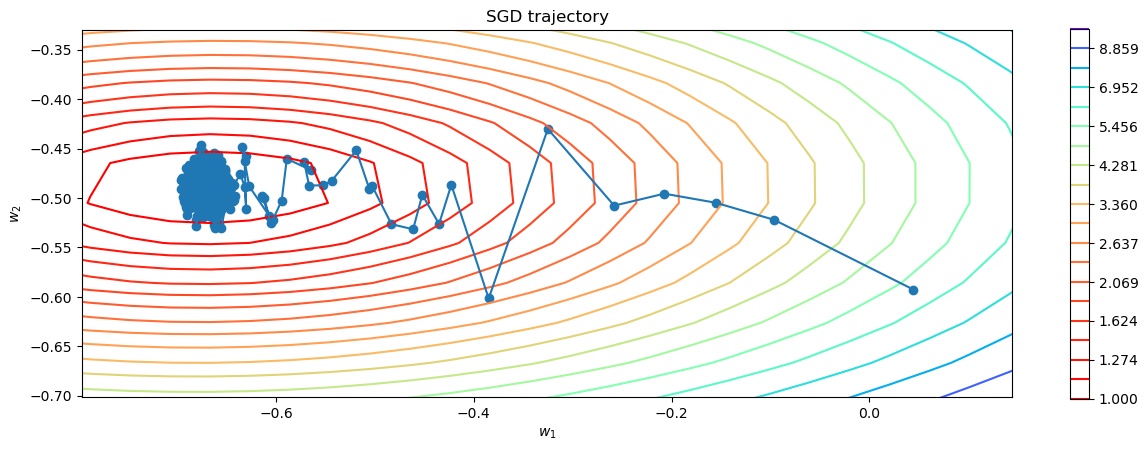

p = 0.6


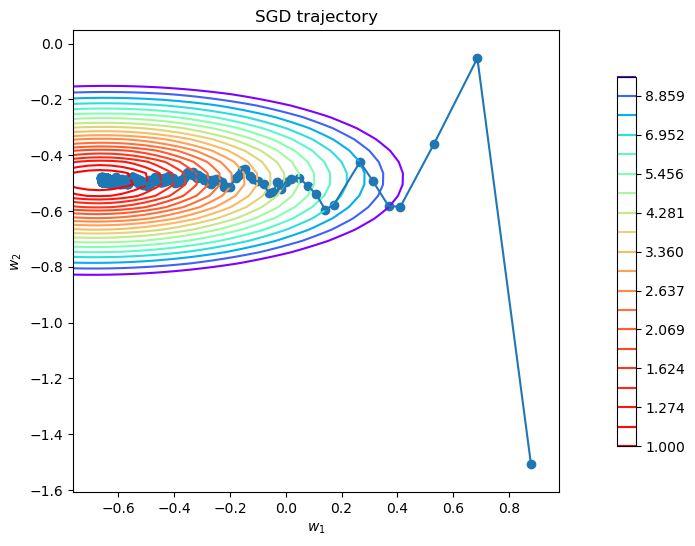

p = 0.9


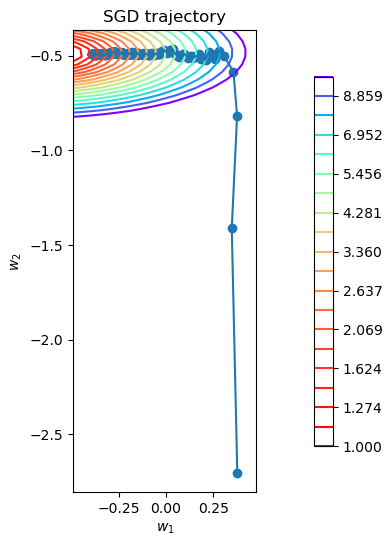

In [14]:
p = [0.1, 0.3, 0.6, 0.9]
lr = [0.0001, 0.001, 0.01, 0.012]

for i in range(len(p)):
    w_list = stochastic_gradient_descent(w_init, X, y, loss, lr= 0.01, batch_size=10, p=p[i])
    print('p =', p[i])
    plot_sgd(w_list, X, y, loss)

In [15]:
k_sgd = []
sgd = []
loss = MSELoss()

w_list = stochastic_gradient_descent(w_init, X, y, loss, lr= 0.01, batch_size=10, p=0.1, n_iterations=100)
for i in range(len(w_list)):
    losses_sgd = loss.calc_loss(X, y, w_list[i])
    sgd.append(losses_sgd)
    k_sgd.append(i)
    

k_gd = []
gd = []
loss = MSELoss()

w_list = gradient_descent(w_init, X, y, loss, 0.01, 100)
for i in range(len(w_list)):
    losses_gd = loss.calc_loss(X, y, w_list[i])
    gd.append(losses_gd)
    k_gd.append(i)
    
    

Text(0, 0.5, 'Значение ошибки')

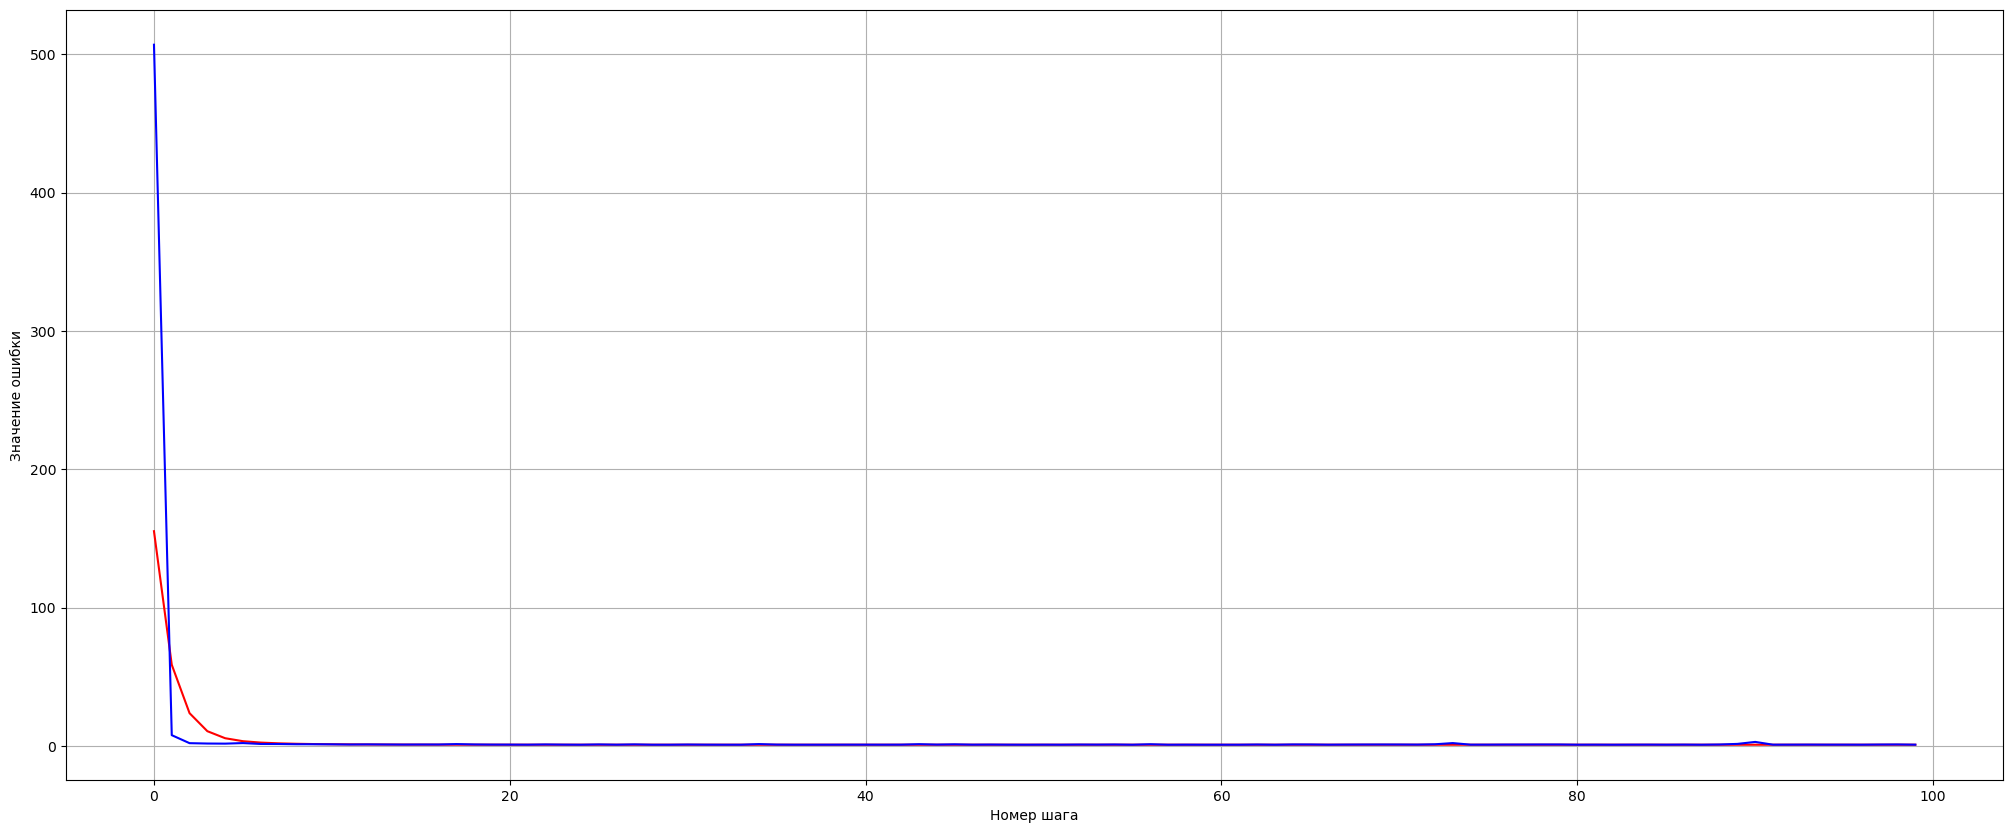

In [16]:
x1 = k_gd
x2 = k_sgd

fig, ax = plt.subplots(figsize = (25,10))

y1= gd
y2 = sgd

ax.plot(x1, y1, color = 'red', label = 'GD')
ax.plot(x2, y2, color = 'blue', label = 'GD')

ax.grid(True)

plt.xlabel('Номер шага')
plt.ylabel('Значение ошибки')

Как можем заметить, стахостический градиентный спуск с затухающим шагом сходится к минимуму быстрее(за меньшее число итераций).